# Apple Stock Price Forecasting using LSTM

This project focuses on forecasting Apple Inc. (AAPL) stock closing prices using a Long Short-Term Memory (LSTM) neural network.  
The objective is to model historical price patterns and evaluate short-horizon predictive performance while avoiding common time-series pitfalls such as data leakage.

## Problem Statement

Financial time-series data exhibits temporal dependency and non-stationarity.  
The goal of this project is to predict future closing prices of Apple stock based on historical market data using a deep learning approach, while ensuring strict separation between training and test data.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


## Dataset Description

The dataset consists of historical daily stock price data for Apple Inc. obtained from publicly available financial sources.

**Features used:**
- Open price
- High price
- Low price
- Close price
- Trading volume

The data is time-ordered and represents real-world financial market behavior.

In [ ]:
df = pd.read_csv("HistoricalQuotes.csv")
df.head()

,Date,Close/Last,Volume,Open,High,Low
0,02/28/2020,$273.36,106721200,$257.26,$278.41,$256.37
1,02/27/2020,$273.52,80151380,$281.1,$286,$272.96
2,02/26/2020,$292.65,49678430,$286.53,$297.88,$286.5
3,02/25/2020,$288.08,57668360,$300.95,$302.53,$286.13
4,02/24/2020,$298.18,55548830,$297.26,$304.18,$289.23


## Data Preprocessing

The following preprocessing steps were applied:
- Conversion of date column to datetime format
- Sorting data chronologically
- Selection of relevant numerical features
- Scaling of features using Min-Max normalization

To prevent data leakage, the scaler was fit only on the training dataset and applied separately to the test dataset.

In [6]:
df.columns = [c.strip().lower().replace("/", "_") for c in df.columns]
df.head()


,date,close_last,volume,open,high,low
0,02/28/2020,$273.36,106721200,$257.26,$278.41,$256.37
1,02/27/2020,$273.52,80151380,$281.1,$286,$272.96
2,02/26/2020,$292.65,49678430,$286.53,$297.88,$286.5
3,02/25/2020,$288.08,57668360,$300.95,$302.53,$286.13
4,02/24/2020,$298.18,55548830,$297.26,$304.18,$289.23


In [7]:
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')
df = df.reset_index(drop=True)


In [8]:
price_cols = ['close_last', 'open', 'high', 'low']

for col in price_cols:
    df[col] = (
        df[col]
        .astype(str)
        .str.replace('$', '', regex=False)
        .str.replace(',', '', regex=False)
    )
    df[col] = pd.to_numeric(df[col], errors='coerce')

df['volume'] = pd.to_numeric(df['volume'], errors='coerce')


In [9]:
df = df.dropna().reset_index(drop=True)

df[['close_last','open','high','low','volume']].dtypes


close_last    float64
open          float64
high          float64
low           float64
volume          int64
dtype: object

In [10]:
data = df[['close_last','open','high','low','volume']]
data.head()


,close_last,open,high,low,volume
0,29.8557,29.3928,29.9286,29.3500,137312041
1,29.8357,29.9900,30.1186,29.6771,141486282
2,29.9043,29.8486,29.9814,29.7057,92846488
3,30.1014,29.8971,30.1314,29.8043,89591907
4,31.2786,30.7057,31.3857,30.6614,224647427


## Data Preprocessing

The following preprocessing steps were applied:
- Conversion of date column to datetime format
- Sorting data chronologically
- Selection of relevant numerical features
- Scaling of features using Min-Max normalization

To prevent data leakage, the scaler was fit only on the training dataset and applied separately to the test dataset.

In [11]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
scaled_data.shape


(2518, 5)

In [12]:
X = []
y = []

window = 60  
for i in range(window, len(scaled_data)):
    X.append(scaled_data[i-window:i])
    y.append(scaled_data[i, 0])  
X = np.array(X)
y = np.array(y)

X.shape, y.shape


((2458, 60, 5), (2458,))

## Train-Test Split Strategy

A time-based split was used instead of random sampling to preserve temporal order.
- Training set: Earlier historical data
- Test set: Most recent unseen data

This approach simulates real-world forecasting conditions where future data is not available during training.


In [13]:
split = int(0.8 * len(X))

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

X_train.shape, X_test.shape


((1966, 60, 5), (492, 60, 5))

## Sequence Generation for LSTM

LSTM models require sequential input data.  
A sliding window approach was used to transform the time-series into supervised learning sequences, where each input consists of a fixed number of past observations used to predict the next time step.

In [14]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(50),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


2025-12-19 08:09:03.348715: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,451 (122.86 KB)

 Trainable params: 31,451 (122.86 KB)

 Non-trainable params: 0 (0.00 B)

## LSTM Model Architecture

The model architecture consists of:
- LSTM layers to capture temporal dependencies
- Dense output layer for price prediction

The architecture is kept intentionally simple to reduce overfitting and improve interpretability.

In [15]:
history = model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1
)


Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - loss: 0.0105 - val_loss: 5.6144e-04
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 1.3248e-04 - val_loss: 3.0057e-04
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 1.1370e-04 - val_loss: 2.8004e-04
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 1.0621e-04 - val_loss: 2.6533e-04
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 1.0487e-04 - val_loss: 2.7524e-04
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 1.1164e-04 - val_loss: 2.7049e-04
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 9.9229e-05 - val_loss: 2.5069e-04
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 9.4395e-05 - val_loss: 2.5289e-04
Epoch 9/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 1.1366e-04 - val_loss: 2.5200e-04
Epoch 10/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 8.9497e-05 - val_loss: 2.3125e-04
Epoch 11/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 8.4198e-05 - 

## Model Training

The model was trained using the training dataset with a validation split to monitor generalization performance.  
Loss convergence was observed over epochs, indicating stable learning behavior.

In [16]:
y_pred = model.predict(X_test)

y_pred_inv = scaler.inverse_transform(
    np.hstack([y_pred, np.zeros((y_pred.shape[0], 4))])
)[:, 0]

y_test_inv = scaler.inverse_transform(
    np.hstack([y_test.reshape(-1,1), np.zeros((y_test.shape[0], 4))])
)[:, 0]


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


## Model Evaluation

Model performance was evaluated on the test dataset using:
- Root Mean Squared Error (RMSE)
- Mean Absolute Error (MAE)

These metrics quantify prediction error in the same units as stock prices, making the results interpretable from a financial perspective.

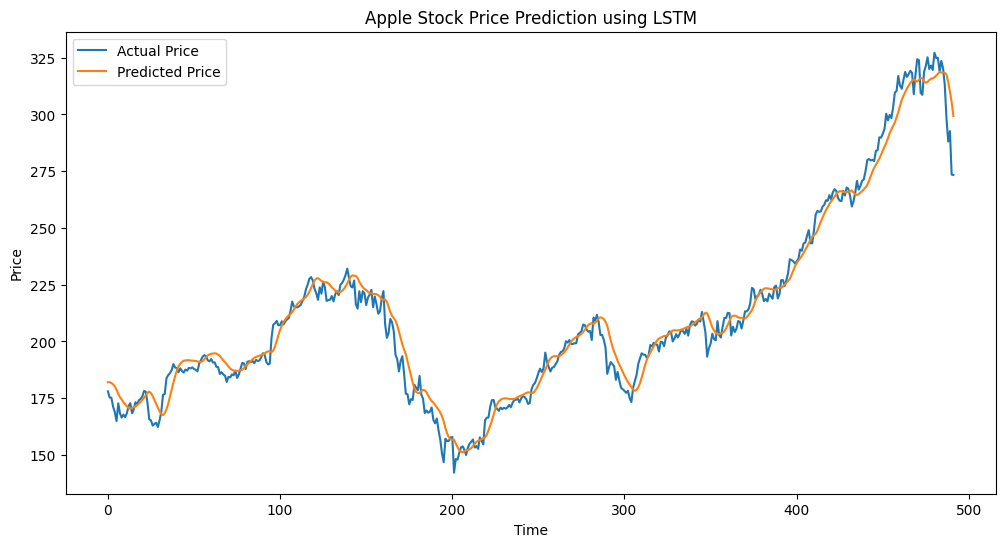

In [17]:
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label="Actual Price")
plt.plot(y_pred_inv, label="Predicted Price")
plt.title("Apple Stock Price Prediction using LSTM")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()


## Results Visualization

The following plots are used:
- Actual vs Predicted prices on the test dataset
- Separate visualization for future price forecasting

Evaluation and forecasting plots are kept separate to avoid misinterpretation.

In [18]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
rmse


np.float64(6.424517923063382)

In [19]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test_inv, y_pred_inv)
mae

4.843238656897177

## Future Price Forecasting

The trained model was used to generate short-horizon future price forecasts using a recursive prediction approach, where each predicted value is fed back as input for the next step.


In [20]:
window = 60
last_window = scaled_data[-window:]
last_window = last_window.reshape(1, window, scaled_data.shape[1])
(1, 60, 5)


(1, 60, 5)

In [21]:
future_days = 30


In [22]:
future_predictions = []

current_window = scaled_data[-window:].copy()

for _ in range(future_days):
    input_window = current_window.reshape(1, window, current_window.shape[1])
    next_pred = model.predict(input_window)[0, 0]
    future_predictions.append(next_pred)

    next_step = current_window[-1].copy()
    next_step[0] = next_pred  # update close price only

    current_window = np.vstack([current_window[1:], next_step])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━

## Limitations

- Stock prices are influenced by external macroeconomic and company-specific events not captured in historical price data
- Long-term forecasting accuracy is limited
- The model does not account for transaction costs or market impact


In [23]:
future_predictions = np.array(future_predictions).reshape(-1, 1)

future_predictions_inv = scaler.inverse_transform(
    np.hstack([future_predictions, np.zeros((future_days, 4))])
)[:, 0]


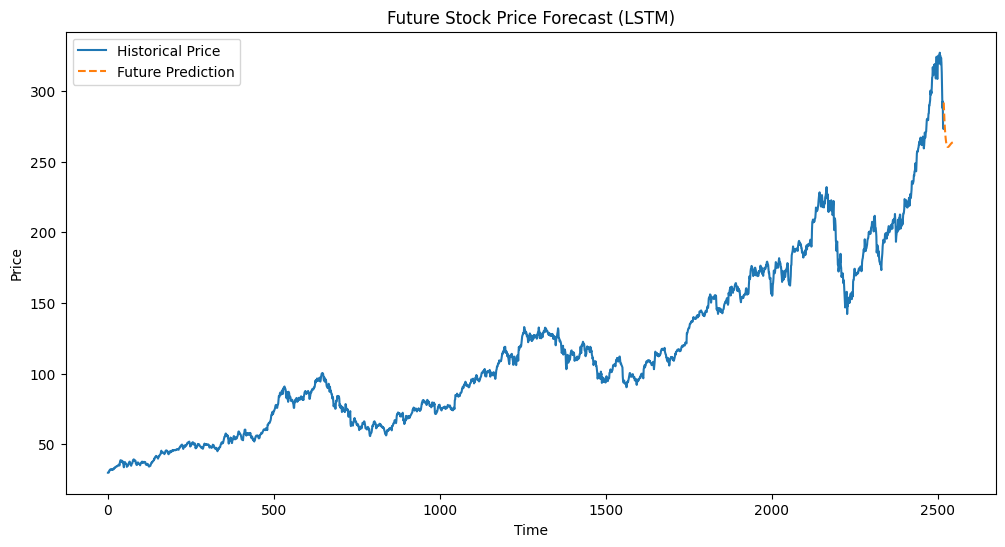

In [24]:
plt.figure(figsize=(12,6))

plt.plot(df['close_last'].values, label="Historical Price")
plt.plot(
    range(len(df), len(df) + future_days),
    future_predictions_inv,
    label="Future Prediction",
    linestyle="--"
)

plt.title("Future Stock Price Forecast (LSTM)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()


## Conclusion

This project demonstrates a disciplined approach to time-series forecasting using LSTM models, with emphasis on proper data handling, evaluation methodology, and interpretability.  
While not intended as a trading strategy, the analysis provides insight into short-term price dynamics in financial markets.
